In [68]:
#Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import warnings
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score,accuracy_score,recall_score,precision_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle, zip_longest, chain
import pickle
from MVDD.MVDD import MVDD
import MVDD.MVDD_Generator as mvGen

%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.rc('font', size=12)
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [85]:
def trainCrossVal(xData, yData, model, numFolds, modelName, showIndividualROC=True):
    
    #make stratified k fold object
    kFold = StratifiedKFold(n_splits=numFolds)
    
    bestAcc = 0

    fprList = []
    tprList = []
    rocList = []

    TPRList = []
    TNRList = []
    PPVList = []
    NPVList = []
    FPRList = []
    FNRList = []
    FDRList = []
    ACCList = []
    AUCList = []

    count = 1
    for train_index, test_index in kFold.split(xData, yData):
        X_train, X_test = xData.iloc[train_index], xData.iloc[test_index]
        y_train, y_test = yData.iloc[train_index], yData.iloc[test_index]

        #fit initial decision tree model
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        #Get Accuracy + Confusion Matrix metrics
        cm = confusion_matrix(y_test,y_pred)

        FP = cm.sum(axis=0) - np.diag(cm)
        FN = cm.sum(axis=1) - np.diag(cm)
        TP = np.diag(cm)
        TN = cm.sum() - (FP + FN + TP)

        # Sensitivity, hit rate, recall, or true positive rate
        TPRList.append(TP / (TP + FN))
        # Specificity or true negative rate
        TNRList.append(TN / (TN + FP))
        # Precision or positive predictive value
        PPVList.append(TP / (TP + FP))
        # Negative predictive value
        NPVList.append(TN / (TN + FN))
        # Fall out or false positive rate
        FPRList.append(FP / (FP + TN))
        # False negative rate
        FNRList.append(FN / (TP + FN))
        # False discovery rate
        FDRList.append(FP / (TP + FP))
        # Overall accuracy
        mvddAcc = (TP + TN) / (TP + FP + FN + TN)
        ACCList.append(mvddAcc)

        print("Accuracy MVDD:", mvddAcc)
        print("Averaged acc for all 5 classes:", np.mean(mvddAcc))


        #calculate average roc across all classes
        y_score = label_binarize(y_pred, classes=[1,2,3,4,5])
        y_test = label_binarize(y_test, classes=[1,2,3,4,5])
        fpr, tpr, roc_auc = getClassROC(y_test,y_score)
        fprList.append(fpr)
        tprList.append(tpr)
        rocList.append(roc_auc)

        AUCList.append(list(roc_auc.values()))

        #show individual fold roc curves
        if showIndividualROC:
            getIndividualROCGraph(y_test, y_score, count, modelName)

        count += 1

    aveFPR = getDictionaryAverages(fprList)
    aveTPR = getDictionaryAverages(tprList)
    ave_roc_auc = getDictionaryAverages(rocList, hasList=False)

    getAverageROCGraph(aveFPR, aveTPR, ave_roc_auc, modelName)

    print("\n*****Averaged Final Classification Results*****")
    print("Sensitivity (TPR): %0.3f(±%0.3f), CI: " % (np.nanmean(TPRList), np.nanstd(TPRList) * 2))
    print("Specificity (TNR): %0.3f(±%0.3f)" % (np.nanmean(TNRList), np.nanstd(TNRList) * 2))
    print("Precision (PPV): %0.3f(±%0.3f)" % (np.nanmean(PPVList), np.nanstd(PPVList) * 2))
    print("Negative Predictive Value (NPV): %0.3f(±%0.3f)" % (np.nanmean(NPVList), np.nanstd(NPVList) * 2))
    print("FPR: %0.3f(±%0.3f)" % (np.nanmean(FPRList), np.nanstd(FPRList) * 2))
    print("FNR: %0.3f(±%0.3f)" % (np.nanmean(FNRList), np.nanstd(FNRList) * 2))
    print("Accuracy: %0.3f(±%0.3f)" % (np.nanmean(ACCList), np.nanstd(ACCList) * 2))
    print("Averaged AUC: %0.3f(±%0.3f)" % (np.nanmean(AUCList), np.nanstd(AUCList) * 2))
    
    
    #get avg roc for each cross val
    rocAvgs = []
    for l in AUCList:
        rocAvgs.append(np.nanmean(l))
    rocAvgs.sort()
    print("roc avgs", rocAvgs)
    cl = rocAvgs[int(0.025 * len(rocAvgs))]
    cu = rocAvgs[int(0.975 * len(rocAvgs))]
    print("Confidence interval ROC Avgs [{:0.3f} - {:0.3}]".format(cl, cu))
    
    rocLongList = list(chain.from_iterable(AUCList))
    rocLongList.sort()
    print("long roc", rocLongList)
    cl = rocLongList[int(0.025 * len(rocLongList))]
    cu = rocLongList[int(0.975 * len(rocLongList))]
    print("Confidence interval ROC Avgs [{:0.3f} - {:0.3}]".format(cl, cu))
    
    return 
    
def getClassROC(y_test, y_score):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(5):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(5)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(5):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= 5

    return fpr, tpr, roc_auc

def getIndividualROCGraph(y_test, y_score, foldNum, modelName):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(5):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(5)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(5):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= 5

    plt.figure(figsize=(10, 8))
    plt.rcParams.update({'font.size': 18})
    # colors = cycle(['aqua', 'darkorange', 'cornflowerblue','palegreen', 'mistyrose'])
    colors = cycle(['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple'])
    for i, color in zip(range(5), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='Class {0} AUC = {1:0.2f})'
                 ''.format(i+1, roc_auc[i]))
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('1 - Specificity (False Positive Rate)')
    plt.ylabel('Sensitivity (True Positive Rate)')
    # plt.title('ROC Curve for Each Score Classification Fold ' + str(foldNum))
    plt.legend(loc="lower right")

    plt.savefig("Model Comparison/Graphs/" + modelName + "ROC for Fold " + str(foldNum) + ".png")
    plt.show()
    
def getDictionaryAverages(dictList, hasList=True):
    d = {}
    for k in dictList[0].keys():
        d[k] = tuple(d[k] for d in dictList)

    if hasList:
        finalDict = {}
        #create average
        for key, value in d.items():
            finalDict[key] = list(map(mapAvg, zip_longest(*value)))
    else:
        finalDict = {}

        for key,value in d.items():
            finalDict[key] = np.mean(value)

    return finalDict

#Helper method to get dictinoary averages
def mapAvg(x):
    x = [i for i in x if i is not None]
    return sum(x, 0.0) / len(x)

def getAverageROCGraph(fpr, tpr, roc_auc, modelName):
    plt.figure(figsize=(10, 8))
    # plt.rc('font', size=14)
    plt.rcParams.update({'font.size': 18})
    # colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'palegreen', 'mistyrose'])
    colors = cycle(['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple'])
    for i, color in zip(range(5), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='Class {0} AUC = {1:0.2f})'
                       ''.format(i + 1, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('1 - Specificity (False Positive Rate)')
    plt.ylabel('Sensitivity (True Positive Rate)')
    # plt.title('Averaged ROC Curve for Each Score Classification')
    plt.legend(loc="lower right")
    plt.savefig("Model Comparison/Graphs/"+ modelName + "Averaged_ROC.png")
    plt.show()

Accuracy MVDD: [0.72380952 0.95238095 0.63809524 0.8        0.95238095]
Averaged acc for all 5 classes: 0.8133333333333332


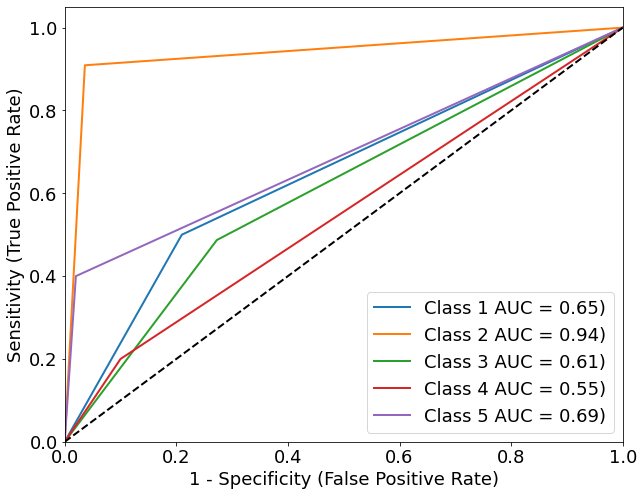

Accuracy MVDD: [0.7047619  0.95238095 0.57142857 0.79047619 0.95238095]
Averaged acc for all 5 classes: 0.7942857142857143


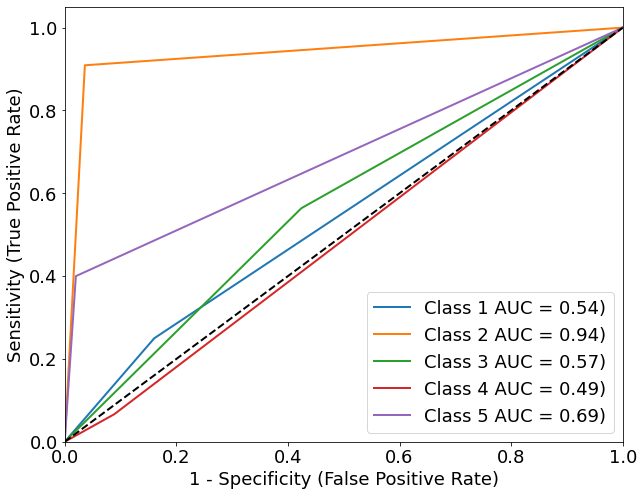

Accuracy MVDD: [0.81730769 0.91346154 0.65384615 0.79807692 0.91346154]
Averaged acc for all 5 classes: 0.8192307692307692


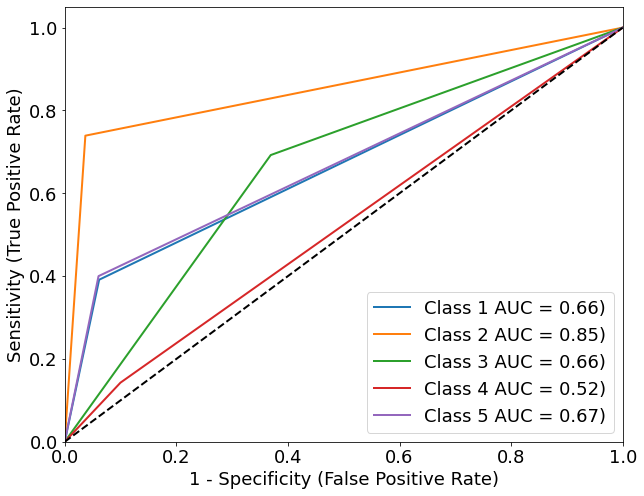

Accuracy MVDD: [0.76923077 0.89423077 0.66346154 0.79807692 0.89423077]
Averaged acc for all 5 classes: 0.8038461538461539


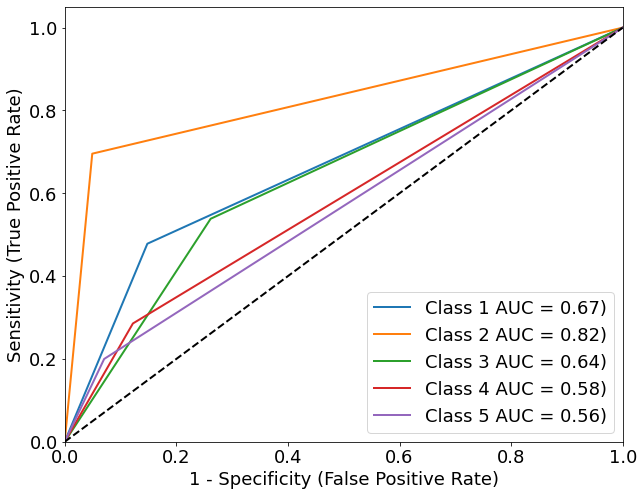

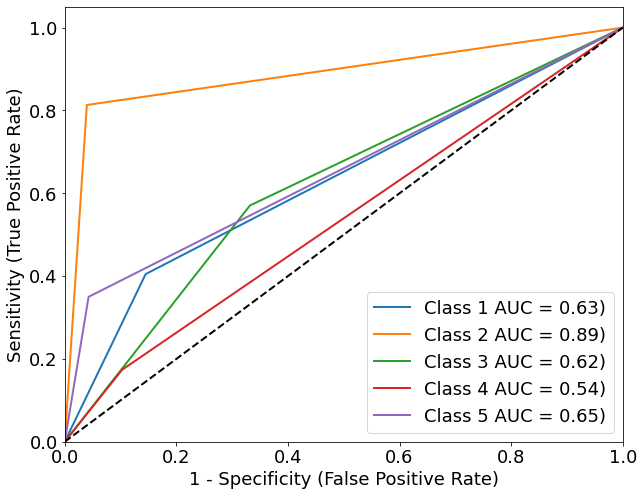


*****Averaged Final Classification Results*****
Sensitivity (TPR): 0.462(±0.467), CI: 
Specificity (TNR): 0.868(±0.229)
Precision (PPV): 0.473(±0.472)
Negative Predictive Value (NPV): 0.869(±0.180)
FPR: 0.132(±0.229)
FNR: 0.538(±0.467)
Accuracy: 0.808(±0.232)
Averaged AUC: 0.665(±0.252)
roc avgs [0.646009042125508, 0.65460902489888, 0.6736997355837936, 0.6857522002019993]
Confidence interval ROC Avgs [0.646 - 0.686]
long roc [0.4888888888888889, 0.5214285714285714, 0.5447530864197531, 0.55, 0.5646464646464646, 0.5699300699300699, 0.5817460317460317, 0.6072261072261073, 0.6384615384615385, 0.6450617283950617, 0.6615384615384615, 0.6647879763821792, 0.6650563607085346, 0.6696969696969697, 0.69, 0.69, 0.8231347289318304, 0.8510466988727858, 0.9364731653888281, 0.9364731653888281]
Confidence interval ROC Avgs [0.489 - 0.936]


In [87]:
dt = DecisionTreeClassifier(random_state=100, max_depth=None)
trainCrossVal(xData, yData, model=dt, numFolds=4, modelName="DecisionTree", showIndividualROC=True)

In [81]:
import math

n = len(hemo)

def CI(val, n):
    ci = 1.96 * math.sqrt((val - (1 - val)) / n)
    return ci
    
CI(0.673, len(hemo))

0.056390504477396824

In [82]:
1.96 * .303

0.59388

# Hemodynamics

In [54]:
#Load original dataframes
hemoData = pd.read_csv('Data/Preprocessed Data/ESCAPE_Hemo.csv', index_col='ID')
allScores = hemoData['Score']
death = hemoData['ScoreDeath']
rehosp = hemoData['ScoreRehosp']
readm = hemoData['ScoreReadmission']
hemoData

,Age,Gender,Race,EjF,RAP,PAS,PAD,PAMN,PCWP,CO,...,RAT,PPRatio,PAPi,SAPi,CPP,PRAPRat,Score,ScoreDeath,ScoreRehosp,ScoreReadmission
ID,,,,,,,,,,,,,,,,,,,,,
72,88.0,2.0,1.0,25.0,24.0,42.0,24.0,30.0,36.0,2.20,...,0.666667,0.266667,0.750000,0.777778,50.0,1.166667,5,5,5,4
72,88.0,2.0,1.0,25.0,18.0,42.0,24.0,30.0,24.0,3.10,...,0.750000,0.272727,1.000000,1.000000,50.0,1.333333,5,5,5,4
81,69.0,1.0,1.0,20.0,10.0,40.0,20.0,27.0,18.0,4.52,...,0.555556,0.242857,2.000000,0.944444,45.0,1.700000,3,3,3,3
81,69.0,1.0,1.0,20.0,12.0,35.0,15.0,25.0,17.0,4.65,...,0.705882,0.571429,1.666667,2.352941,45.0,3.333333,3,3,3,3
814,58.0,1.0,1.0,NaN,3.0,51.0,19.0,30.0,18.0,4.10,...,0.166667,0.566667,10.666667,1.888889,44.0,11.333333,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98508,57.0,1.0,98.0,30.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,37.0,NaN,1,1,1,1
99302,41.0,1.0,2.0,15.0,19.0,87.0,37.0,54.0,44.0,3.90,...,0.431818,0.642857,2.631579,1.227273,13.0,2.842105,4,4,4,5
99302,41.0,1.0,2.0,15.0,11.0,70.0,28.0,44.0,28.0,5.30,...,0.392857,1.088608,3.818182,3.071429,13.0,7.818182,4,4,4,5


In [55]:
# Preprocess and create training and testing sets
hemo = hemoData.drop('Score', axis=1)
# hemo = hemo.dropna()
# yData = hemo['ScoreDeath']

hemo = hemo.drop('ScoreDeath', axis=1)
hemo = hemo.drop('ScoreRehosp', axis=1)
hemo = hemo.drop('ScoreReadmission', axis=1)
hemo = hemo.replace(np.inf, 0)
hemo = hemo.fillna(0)

xData = hemo
yData = death
xData.shape, yData.shape

((418, 28), (418,))

In [52]:
# Drop NA

# # Preprocess and create training and testing sets
# hemo = hemoData.drop('Score', axis=1)
# hemo = hemo.dropna()
# yData = hemo['ScoreDeath']

# hemo = hemo.drop('ScoreDeath', axis=1)
# hemo = hemo.drop('ScoreRehosp', axis=1)
# hemo = hemo.drop('ScoreReadmission', axis=1)
# # hemo = hemo.replace(np.inf, 0)
# # hemo = hemo.fillna(0)

# xData = hemo
# # yData = death
# xData.shape, yData.shape

((145, 28), (145,))

In [30]:
# Base model regression

In [31]:
# base model knn

Accuracy MVDD: [0.70238095 0.94047619 0.5952381  0.75       0.94047619]
Averaged acc for all 5 classes: 0.7857142857142858


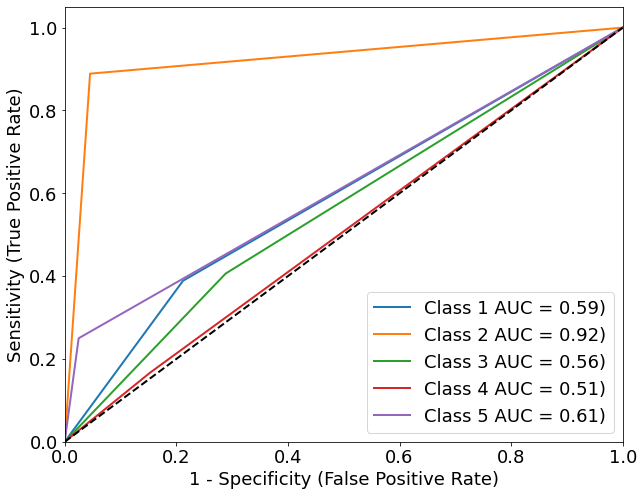

Accuracy MVDD: [0.77380952 0.92857143 0.61904762 0.77380952 0.92857143]
Averaged acc for all 5 classes: 0.8047619047619048


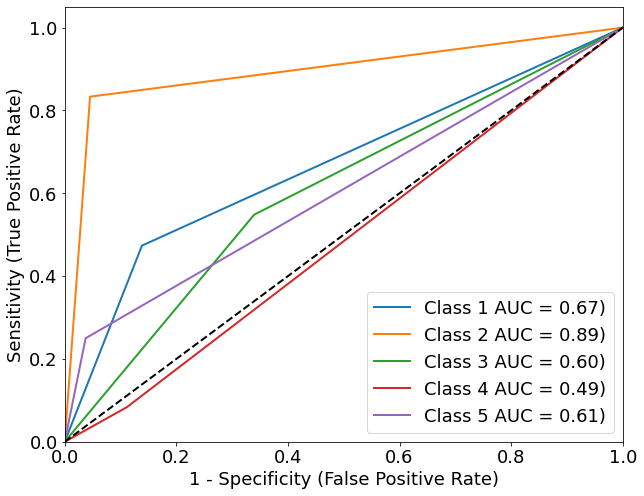

Accuracy MVDD: [0.75       0.95238095 0.60714286 0.78571429 0.95238095]
Averaged acc for all 5 classes: 0.8095238095238095


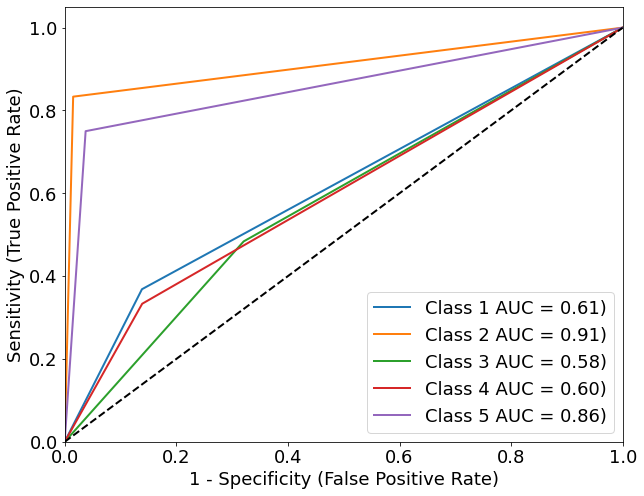

Accuracy MVDD: [0.72289157 0.98795181 0.60240964 0.78313253 0.98795181]
Averaged acc for all 5 classes: 0.8168674698795181


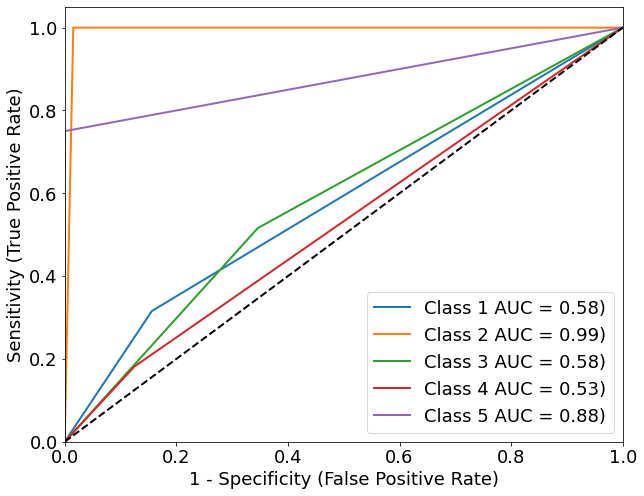

Accuracy MVDD: [0.79518072 0.89156627 0.72289157 0.75903614 0.89156627]
Averaged acc for all 5 classes: 0.8120481927710845


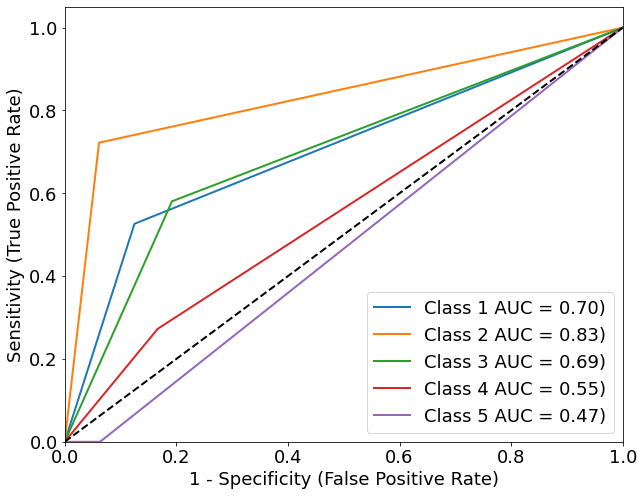

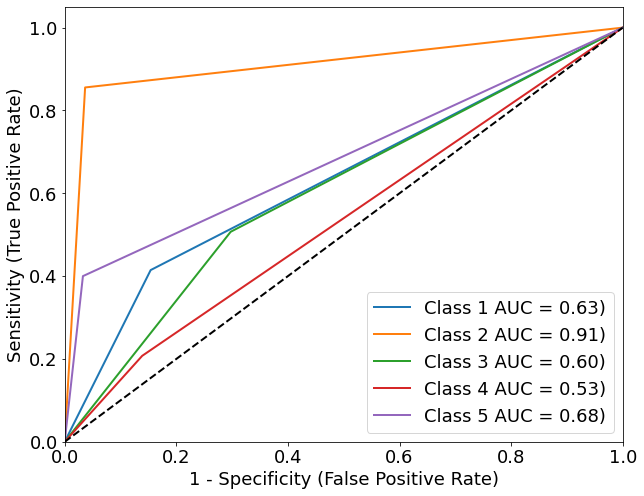

roc list [{0: 0.5883838383838383, 1: 0.9217171717171717, 2: 0.5588942307692308, 3: 0.5069444444444444, 4: 0.6125}, {0: 0.6676113360323886, 1: 0.893939393939394, 2: 0.6043822276323798, 3: 0.48611111111111105, 4: 0.60625}, {0: 0.6149797570850203, 1: 0.9090909090909092, 2: 0.5815581253804017, 3: 0.5972222222222222, 4: 0.85625}, {0: 0.5797697368421053, 1: 0.9923076923076923, 2: 0.5849875930521091, 3: 0.5284090909090909, 4: 0.875}, {0: 0.700657894736842, 1: 0.8303418803418804, 2: 0.6941687344913151, 3: 0.553030303030303, 4: 0.46835443037974683}]


NameError: name 'ave_rpc_auc' is not defined

In [61]:
# base model decision tree

dt = DecisionTreeClassifier(random_state=100, max_depth=None)
trainCrossVal(xData, yData, model=dt, numFolds=5, modelName="DecisionTree", showIndividualROC=True)

In [ ]:
# random forest